<h1 style="color: #aadafa; text-align: center; font-size: 48px; margin-bottom: 0.2em;">
PW 4 - Medical Images Segmentation
<h1>
<p style="text-align: center; font-size: 18px; margin-top: 0.5em;">
<strong> Marie Pizzini</strong> 
</p>
<p style="text-align: center; font-size: 18px; margin-top: 0.5em;">
Telecom Paris - January 2024
</p>



In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.path import Path
# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho  
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian

from skimage.color import rgb2gray
from skimage.segmentation import active_contour 
from skimage.segmentation import morphological_geodesic_active_contour
from skimage.segmentation import disk_level_set



# For Kmeans
import cv2 


Working_directory = os.getcwd()
print('Working_directory = ',Working_directory)


Working_directory =  /Users/marie/Documents/Cours/IMA/IMA204/TP-Marie-IMA204


In [3]:
def my_kmeans(image,k):
    #k = number of clusters
    
    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                None, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    centers = np.uint8(centers) # convert data into 8-bit values 
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image,segmented_labels


def my_colormap_white_bkg(Colormap_name,numLabels):
    #numLabels = number of colors
    
    Colormap  = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256/256, 256/256, 256/256, 1])
    max_color = np.array([0/256, 0/256, 0/256, 1])
    newcolors[numLabels-1, :] = max_color
    newcolors[0, :] = bkg_color
    newcmp = ListedColormap(newcolors)
    return newcmp

# Brain MRI

Here you can select medial slices of the brain of **4 different subjects**. You also have manual segmentations of the corpus callosum.

Variables defined: <br>
* brainMRI_path
* listImagesbrainMRI
* Seg_brain_ex
* Img_brain_ex

There are 4 brain MRI images
['/Users/maelleguillouzic/Downloads/data/brainMRI/MRIs1-seg.png', '/Users/maelleguillouzic/Downloads/data/brainMRI/MRIs2-seg.png', '/Users/maelleguillouzic/Downloads/data/brainMRI/MRIs3-seg.png', '/Users/maelleguillouzic/Downloads/data/brainMRI/MRIs4-seg.png']
Reading image  /Users/maelleguillouzic/Downloads/data/brainMRI/MRIs4.png


Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

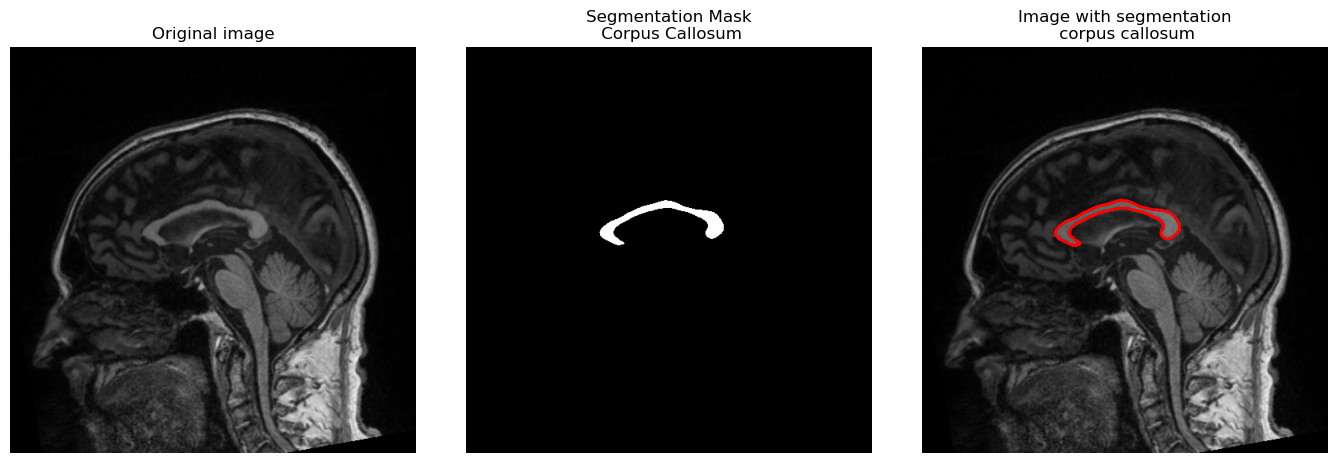

In [5]:
brainMRI_path = Working_directory + '/data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

# Choose a brain MRI and plot it with the ground truth segmentation
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename) 

print('Reading image ', filename)

if Img_brain_ex.shape != Seg_brain_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC      = Seg_brain_ex==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_brain_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum");
grid[2].imshow(Img_brain_ex, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")



# ASSIGNMENT:

**Question** 
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure of interest**. For the postprocessing you can rely on extraction of connected components and apply to criteria (size, shape, position,..) to extract the composant that most likely corresponds to the structure of interest. 


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* Cropping the field of view to remove the background (a common issue in medical images)
* Target a range of intensity values based on learning from the gt masks and corresponding images 
* Learn priors on shape/intensity statistics from the provided gt masks


## Kmeans routine to segment your images
Kmeans is very often used as pre-segmentation to initialise a finer segmentation.

Provides a segmentation of the image using k-means clustering.
Be careful: Kmeans uses random initialisation and is therefore different at each run and randomly assigns  labels to clusters (0,1,2,...,K).

 



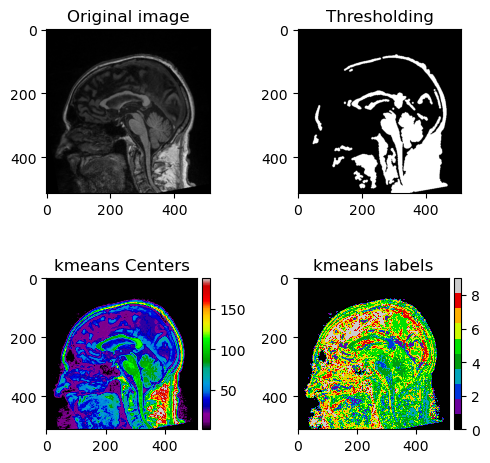

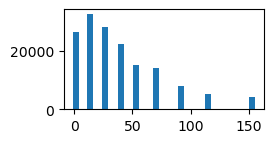

Your Target_value =  97
Distance of your Target_value to Centers =  [95 44 18 92  5 70 27 56 57 83]
Your selected label (starting with 0)=  4


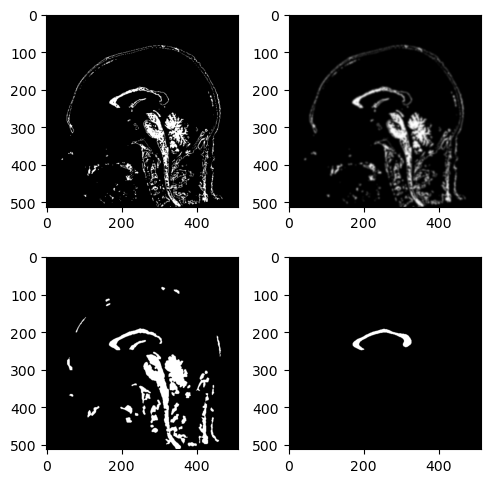

In [10]:
# Image use-case and HYPER-PARAMETER values provided as a good start

# Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
# nber_clusters    = 10; Target_value_thresh = 180 # For cardiac image
# Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
# nber_clusters       = 10; Target_value_thresh = 150 # For abdo image
Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
nber_clusters     = 10; Target_value_thresh = 50 # For brain image




# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')


# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Your Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(Img_seg_gt, cmap='gray')

fig.tight_layout()
plt.show()






Max value in labels =  21
Number of connected components =  22


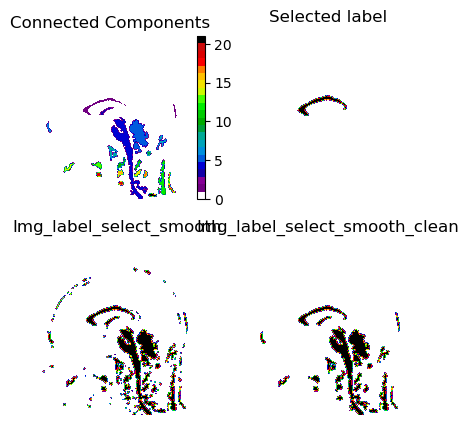

In [11]:
Img_label_select_filter = gaussian(Img_label_select, 2, 
                            preserve_range=True)
Img_label_select_smooth = Img_label_select_filter>0.25
Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth, min_size=150,connectivity=1),
    area_threshold=150)

# Extract connected components
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels = ',labels.max())
print('Number of connected components = ',numLabels)

# Extract 1 connected component
thresh = labels==1

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')
ax[2].imshow(Img_label_select_smooth, cmap=Colormap)
ax[2].set_title('Img_label_select_smooth')
ax[2].axis('off')
ax[3].imshow(Img_label_select_smooth_clean, cmap=Colormap)
ax[3].set_title('Img_label_select_smooth_clean');
ax[3].axis('off');




## Implementation of my segmentation pipeline

## Presentation of the Data Set
I decided to focus on the brain MRI. I chose the third MRI as the ground truth and reference for the rest of the algorithm
The test will be runned on the first and last MRI provided

In [66]:
brainMRI_path = Working_directory + '/data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')

#Ground truth
indexImRef     = 2 
filename_segRef = listImagesbrainMRI[indexImRef]
filenameRef     = filename_segRef[:-8] + '.png'
Img_brain_ex_Ref = cv2.imread(filenameRef) #Used the cv2 library to read the image because Pillow had trouble with the type format of this image
Img_brain_ex_Ref = cv2.cvtColor(Img_brain_ex_Ref, cv2.COLOR_BGR2GRAY) 

#Load Test Images 
indexIm      = 3 
filename_seg = listImagesbrainMRI[indexIm]
filename     = filename_seg[:-8] + '.png'
Seg_brain_ex = imread(filename_seg)
Img_brain_ex = imread(filename)

indexIm2     = 0 
filename_seg2 = listImagesbrainMRI[indexIm2]
filename2     = filename_seg2[:-8] + '.png'
Seg_brain_ex_2 = imread(filename_seg2)
Img_brain_ex_2 = imread(filename2) 

#Parameters
# CLAHE parameters for contrast enhancement
clipLimit = 2.0
tileGridSize = (8, 8)
clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)

# Morphological GAC parameters
Thresh_cont_val='auto'
Balloon_weight = 1
Smooth_cont_iter = 1
Niter_snake = 100
center = [75, 130]
radius = 5

# Image processing parameters
area_threshold = 500
connectivity = 1
disk_radius = 3
threshold_value = 152


## Presentation of the techniques used
#### Preprocessing

I first decided to crop the imaged to only focus on a zoomed portion of it containing the corpus collosum (which is the zone we want to segment).

Because we will be using an intensity threshold to get a binary image, I wanted the two examples to have the same gray value repartition so that they would be comparable and work with the same threshold value.

To do so, I implemented a technique we saw in a TP of IMA201 which consist in applying the histogram of an image onto another one. I used the histogram of the reference image and applied it on the two test images (another approach could be to apply the histogram of the first test image on the second test image). After this step, the two examples now have a similar repartition of gray values. 

For the threshold to work properly, it is important to boost the contrast of our examples which is what was done using the cv2 CLAHE method. 

#### Algortihm used for segmentation

The preprocessing of the images is now done, we can apply some morphological transformations and apply a threshold. Small holes and objects were removed and a threshold of 150 was used to obtain a binary image. 

Then, to precisely segment the coprus callosum, I used a deformable model we saw in class. I first tried to implement a classic snake but the initialization was too tedious so I abandonned this idea and used instead the GAC active contour algortihm with a balloon force. The snake was therefore initialized as a small disc inside the corpus callosum and expanded. The binary image was used for the segmentation. 

#### Post processing

I realised that the contour obtained at the end of the algorithm was not smooth so a gaussian filter was applied to get a smoother contour.

The results are displayed on both the original image and on the binary image



In [14]:
#Preprocessing of the reference image to have the same size as the test images for final comparison
Img_brain_ex_Ref=cv2.resize(Img_brain_ex_Ref,(512,512))

#Preprocessing of the reference image to only focus on the zone where the corpus callosum is located
height, width = Img_brain_ex_Ref.shape
new_height, new_width = height // 2, width // 2
start_row = (height - new_height) // 2
start_col = (width - new_width) // 2
cropped_image_Ref = Img_brain_ex_Ref[start_row:start_row + new_height, start_col:start_col + new_width]
cropped_image_Ref = cv2.normalize(cropped_image_Ref, None, 0, 255, cv2.NORM_MINMAX)
contrast_enhanced_Ref = clahe.apply(cropped_image_Ref)

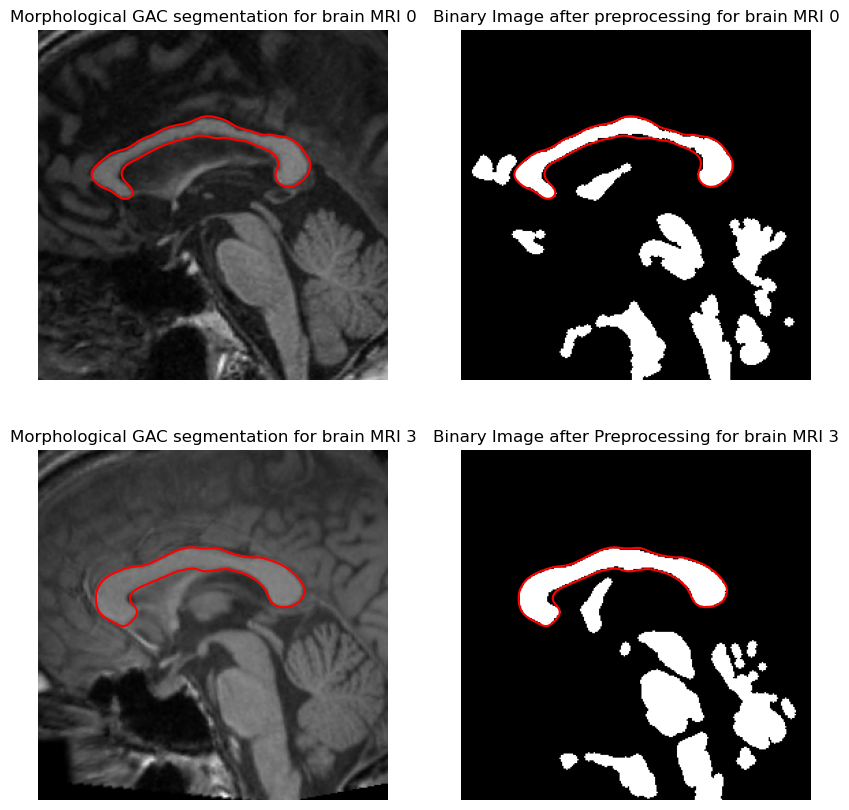

In [67]:
#Segmentation Algorithm 

img = [Img_brain_ex,Img_brain_ex_2]
ls_final =[]
ls_final_smooth =[]
cropped_image_final = []
binary_image_final = []

#Begining of the segmentation loop

for i in range(2):
    img[i] = cv2.normalize(img[i], None, 0, 255, cv2.NORM_MINMAX)

    #Preprocessing of the test images to only focus on the corpus callosum
    height, width = img[i].shape
    new_height, new_width = height // 2, width // 2
    start_row = (height - new_height) // 2
    start_col = (width - new_width) // 2
    cropped_image = img[i][start_row:start_row + new_height, start_col:start_col + new_width]
   
    #Applying the histogram of the reference image to the test images to have the same contrast
    ushape=cropped_image.shape
    uligne=cropped_image.reshape((-1,)) 
    vligne=contrast_enhanced_Ref.reshape((-1,))
    ind=np.argsort(uligne)
    new=np.zeros(uligne.shape,uligne.dtype)
    new[ind]=np.sort(vligne)
    new=new.reshape(ushape)

    #Enhancing the contrast of the new test images
    contrast_enhanced = clahe.apply(new)
    

    #Applying the morphological GAC algorithm
    binary_image          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          contrast_enhanced > threshold_value, 
                            min_size=area_threshold,connectivity=connectivity),
                             area_threshold=area_threshold)
    binary_image = morphology.opening(binary_image, morphology.disk(disk_radius))
    img_to_seg= binary_image.astype('float64')
    init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[75,130], radius=5)
    evolution = []
    callback = store_evolution_in(evolution)
    Niter_snake      = 100
    ls       = morphological_geodesic_active_contour(
                img_to_seg, Niter_snake, init_ls, 
                smoothing=Smooth_cont_iter, balloon=Balloon_weight,
                threshold=Thresh_cont_val,
                iter_callback=callback);

    #Post Porcessing : Smoothing the contour and applying a threshold to get a binary image
    ls_smooth = (gaussian(ls, 3, 
                            preserve_range=True))
    ls_f         = ls_smooth>0.52
    
    #Store the results
    ls_final.append(ls_f)
    ls_final_smooth.append(ls_smooth)
    cropped_image_final.append(cropped_image)
    binary_image_final.append(binary_image)


#Display the results

fig, axes = plt.subplots(2,2, figsize=(10, 10))
ax        = axes.ravel()
ax[0].imshow(cropped_image_final[0], cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls_final_smooth[0], [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation for brain MRI 0", fontsize=12);


ax[1].imshow(binary_image_final[0], cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls_final_smooth[0], [0.5], colors='r');
ax[1].set_title("Binary Image after preprocessing for brain MRI 0", fontsize=12);

ax[2].imshow(cropped_image_final[1], cmap="gray");
ax[2].set_axis_off();
ax[2].contour(ls_final_smooth[1], [0.5], colors='r');
ax[2].set_title("Morphological GAC segmentation for brain MRI 3", fontsize=12);

ax[3].imshow(binary_image_final[1], cmap="gray");
ax[3].set_axis_off();
ax[3].contour(ls_final_smooth[1], [0.5], colors='r');
ax[3].set_title("Binary Image after Preprocessing for brain MRI 3", fontsize=12);


plt.show();

        
    
    

## Visualization of the results 
To visually compare the two results, we can plot the result next to the the ground truth binary mask. I have also decided to show the contour of the ground truth I  on the results' mask.

We can see that visually the two corpus callosum segmented seem to be similar to the ground truth. Only some small imperfections are visible. The area I segmented seem to have a little growth on the bottom contour. 

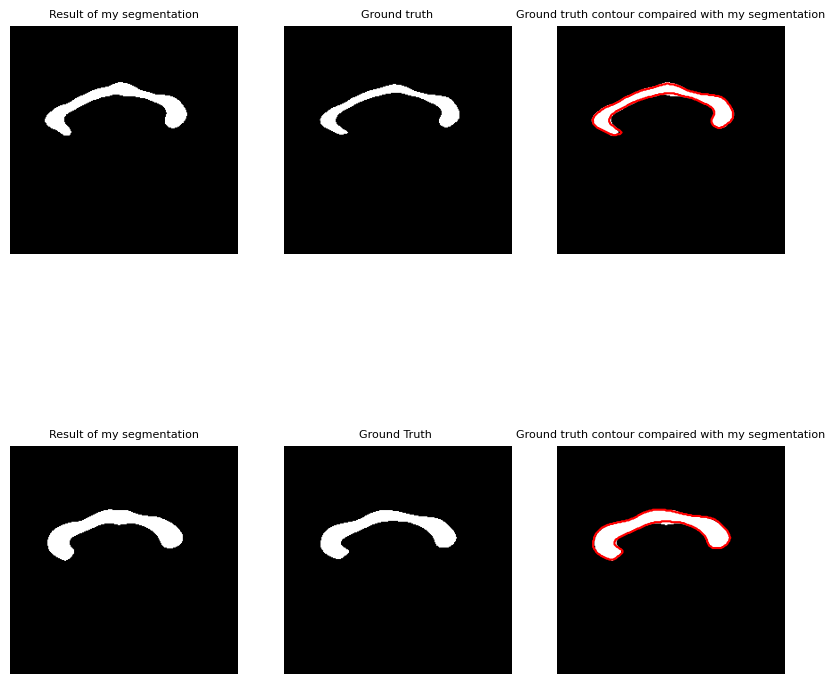

In [68]:
#Plotting the results with the ground truth

segmentation_truth =[Seg_brain_ex,Seg_brain_ex_2]
cropped_segmentation_truth = []

for i in range(2):
    #Preprocessing of the test images to only focus on the corpus callosum
    height, width = segmentation_truth[i].shape
    new_height, new_width = height // 2, width // 2
    start_row = (height - new_height) // 2
    start_col = (width - new_width) // 2
    cropped_image = segmentation_truth[i][start_row:start_row + new_height, start_col:start_col + new_width]
    cropped_segmentation_truth.append(cropped_image)

fig, axes = plt.subplots(2,3, figsize=(10, 10))
ax        = axes.ravel()
ax[0].imshow(ls_final[0], cmap="gray");
ax[0].set_axis_off();
ax[0].set_title("Result of my segmentation", fontsize=8);

ax[1].imshow(cropped_segmentation_truth[0], cmap="gray");
ax[1].set_axis_off();
ax[1].set_title("Ground truth", fontsize=8);

ax[2].imshow(ls_final[0], cmap="gray");
ax[2].set_axis_off();
ax[2].contour(cropped_segmentation_truth[0], [0.5], colors='r');
ax[2].set_title("Ground truth contour compaired with my segmentation", fontsize=8);



ax[3].imshow(ls_final[1], cmap="gray");
ax[3].set_axis_off();
ax[3].set_title("Result of my segmentation", fontsize=8);

ax[4].imshow(cropped_segmentation_truth[1], cmap="gray");
ax[4].set_axis_off();
ax[4].set_title("Ground Truth ", fontsize=8);

ax[5].imshow(ls_final[1], cmap="gray");
ax[5].set_axis_off();
ax[5].contour(cropped_segmentation_truth[1], [0.35], colors='r');
ax[5].set_title("Ground truth contour compaired with my segmentation", fontsize=8);





plt.show();

## Last Step : Calculation of the Dice coefficient for the two example segmented 

In [71]:
#Calculating the Dice Coefficient
for i in range(2):
    #The two maks do not have the same type (one is boolean and the other is uint8 with 0 and 255) so we need to convert them to the same type
    flat_image1 = ls_final[i].flatten()
    flat_image2 = cropped_segmentation_truth[i].flatten()
    flat_image2_bool = (flat_image2 == 255)
    intersection = np.sum(np.logical_and(flat_image1, flat_image2_bool))
    total_pixels_image1 = np.sum(flat_image1)
    total_pixels_image2 = np.sum(flat_image2_bool)
    dice_coefficient = (2.0 * intersection) / (total_pixels_image1 + total_pixels_image2)
    print(dice_coefficient)


0.8900365827415537
0.9415795785506254


We get coefficient that are quite close to one. The second example has better results than the first one. 

## Critical analysis of the technique used

Using an active contour algorithm helps us get a correct result with a Dice coefficient really close to one. However this technique can be automated only if the images have the zone we want to segmented at the same coordinates on all of the images. If it is not the case, the initialisation of the snake will need to be made manually for each individual image (we will need to adapt the center of the initialisation disc each time)

In the example used, the coordinates of the corpus callosum were the same on the two images and it was therefore easy to initialize the snake at the same position for the two images. 
